#  <center> Heat Budget </center> #

The heat budget can written in the familiar form:
\begin{equation}
\frac{\partial T}{\partial t} + \nabla \cdot \textbf{u}T = \frac{\partial Q}{\partial z}
\end{equation}
 Where Q is the surface heat flux. Using a Reynolds decomposition to split the budget into eddy and mean transport terms gives:
 
\begin{equation}
\frac{\partial \overline{v}\overline{T}}{\partial y } + \frac{\partial \overline{w}\overline{T}}{\partial z } + \frac{\partial \overline{v'T'}}{\partial y } + \frac{\partial \overline{w'T'}}{\partial z } = \frac{\partial Q}{\partial z}.
\end{equation}

Advective transports can be written as $ \displaystyle{\nabla \cdot \textbf{v}T = \textbf{v} \cdot \nabla T} $. The $\overline{v'T'}$ and $\overline{w'T'}$ terms can be decomposed into an along-isopycnal term and a horizontal component:

\begin{equation}
\left( \overline{v'T'},\overline{w'T'} \right) =  \underbrace{\left(\frac{\overline{w'T'}}{S_p}, \overline{w'T'}\right)}_\text{along $\overline{T}$}  + \underbrace{\left(\overline{v'T'} - \frac{\overline{w'T'}}{S_p}, 0\right)}_\text{remaining horizontal}, 
\end{equation}

which can be substituted back in to the heat budget:
\begin{equation}
\overline{v}\frac{\partial \overline{T}}{\partial y } + \overline{w}\frac{\partial \overline{T}}{\partial z } + \frac{\partial \left( \overline{v'T'}-\frac{\overline{w'T'}}{S_p}\right)}{\partial y }+ \frac{\partial \frac{\overline{w'T'}}{S_p}}{\partial y } + \frac{\partial \overline{w'T'}}{\partial z } = \frac{\partial Q}{\partial z}.
\end{equation}
The along isopycnal eddy fluxes can be written as:
\begin{equation}
\textbf{v}^* . \nabla \overline{T}
\end{equation}

and 

\begin{equation}
v^* = \frac{\partial \Psi ^*}{\partial z}, \quad w^* = \frac{\partial \Psi ^*}{\partial y} \\ \, \text{ and } \, \\
\overline{v} = \frac{\partial \overline{\Psi } }{\partial z}, \quad \overline {w} = \frac{\partial \overline{\Psi} }{\partial y}.
\end{equation}

Substituting these in gives:

\begin{equation}
v^* \frac{\partial \overline{T}}{\partial y }= \frac{\partial \frac{\overline{w'T'}}{S_p}}{\partial y}, \quad w^* \frac{\partial \overline{T}}{\partial z }= \frac{\partial \overline{w'T'}}{\partial z}. 
\end{equation}
So Eq. then becomes:
\begin{equation}
\textbf{$v_{res}$}. \nabla \overline{T} = \frac{\partial Q}{\partial z}- \frac{\partial \left(\overline{v'T'}-\frac{\overline{w'T'}}{S_p}\right)}{\partial y }.
\end{equation}

Residual mean theory as used in \citep{Marshall2003} allows for further simplifications such as neglecting the $\frac{\partial \overline{v'T'}-\frac{\overline{w'T'}}{S_p}}{\partial y }$ term representing the diabatic eddy contribution to the heat budget. When studying the effect of a changing stratification north of the ACC, such neglect leads to serious errors in the calculation. 
In terms of the ROC we must write:

\begin{equation}
J(\Psi_{res},\overline{T})=\frac{\partial Q}{\partial z}- \frac{\partial \left(\overline{v'T'}-\frac{\overline{w'T'}}{S_p}\right)}{\partial y },
\end{equation}

which can be alternatively written as

\begin{equation}
J(\Psi_{res},\overline{T}) = \underbrace{\frac{\partial Q}{\partial z}}_\text{Air-sea fluxes} - \underbrace{\frac{\partial \left(\overline{v'T'} - \frac{-\Psi ^* T_y}{S_p} \right)}{\partial y }}_\text{Diabatic eddies} .
\end{equation} 

Evaluated at the base of the surface diabatic layer for simplicity in calculations:
\begin{equation}
 \Psi_{res} |_{hml} \frac{\partial T_o}{\partial y} =  Q - \int_{hml}^{0} \frac{\partial \left(\overline{v'T'} - \frac{-\Psi ^* T_y}{S_p} \right)}{\partial y } \mathrm{d}z
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
from scipy.interpolate import interp1d
from scipy import interpolate
from numba import autojit
import numdifftools as nd
import numdifftools.nd_algopy as nda
from pylab import *
from matplotlib import gridspec
import netCDF4
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from useful import *
from Flat_channel import *
from HB_Plot import nf, fmt
import SG as SG
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
%matplotlib inline

In [2]:
# Some parameters
Full = 'N'  # 9 Pannels isn't ideal for presentations N option give 4 plots
Qplot = 'Y'

In [3]:
if Full == 'N':
    tau = ['3', '300', '3000', 'Closed']
elif Full == 'Extremes':
    tau = ['3','Closed']
else:
    tau = ['3', '10', '30', '100', '300',
           '1000', '3000', '10000', 'Closed']
Figletter = ['a) ','b) ','c) ','d) ','e)','f)','g)','h)','j)']
# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'daynokpp/PSI.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)

Check continuity equation

\begin{equation}
\frac{\partial \overline{v}}{\partial y} + \frac{\partial \overline{w}}{\partial z}  = 0
\end{equation}

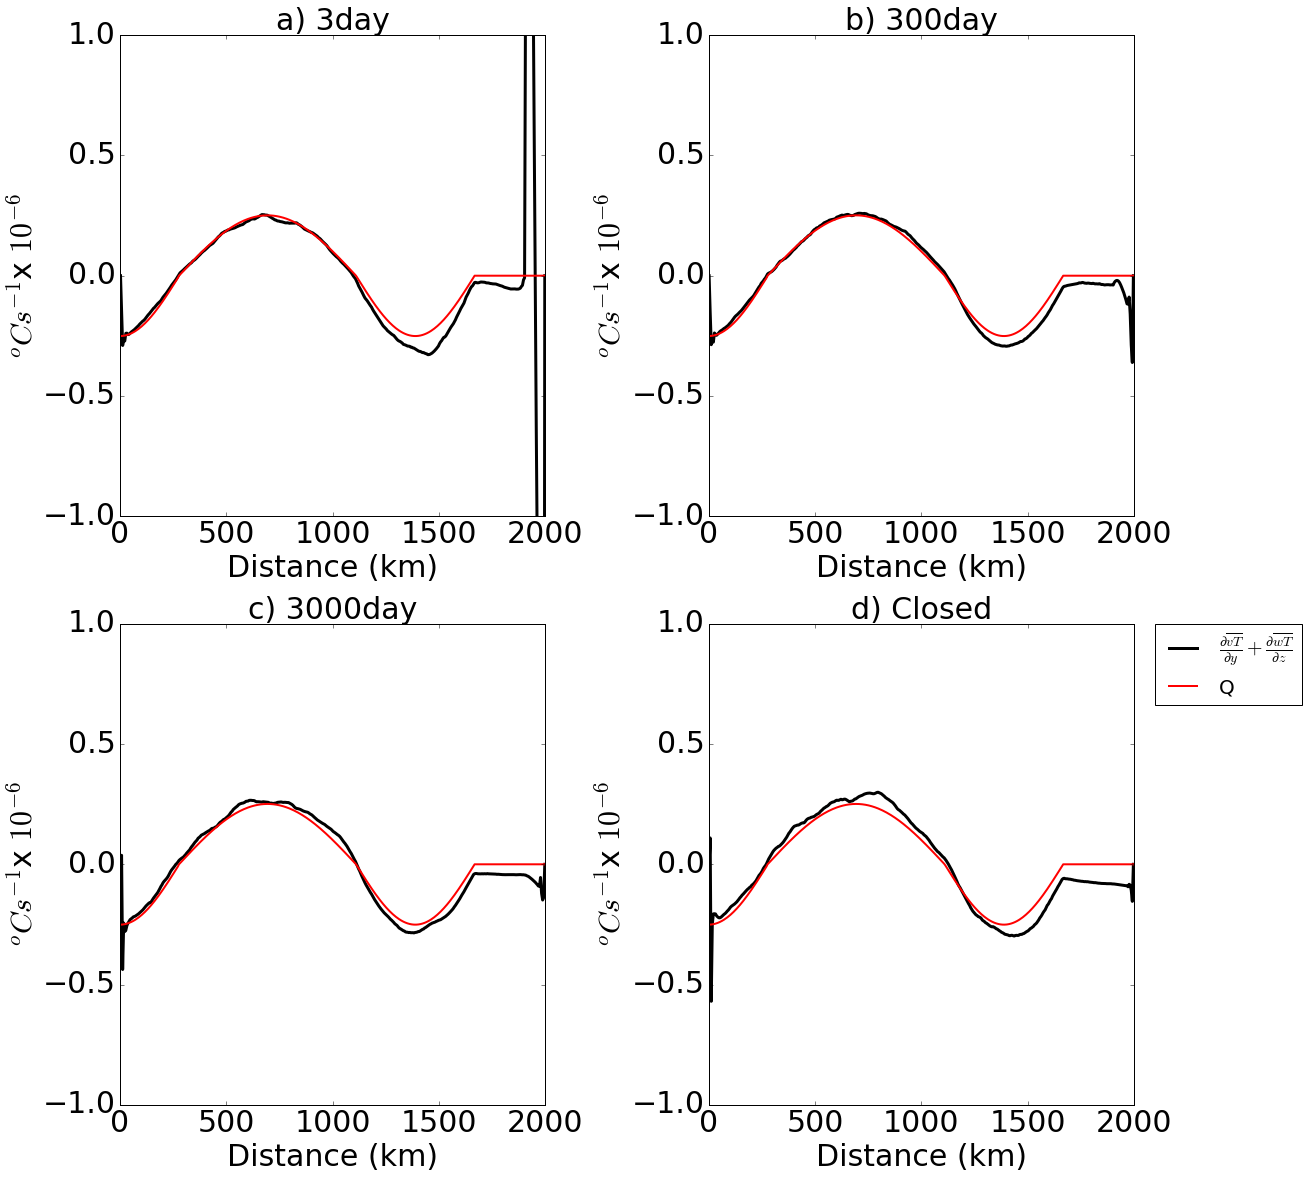

In [9]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar         
    # put everything on the C Grid                    
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVT = (VT[:,0:-1,:]-VT[:,1::,:])*CellVol
    dWT = (WT[1::,:,:]-WT[0:-1,:,:])*CellVol[0:-1,:,:]
    Adv = (dVT.sum(axis=0) + dWT.sum(axis=0))/sum(CellVol)
    Diff = -(5000*Adv).mean(axis=1)
    Ly = 2000e3
    Lx = 1000e3
    nx = np.round(Lx/5000)
    ny = np.round(Ly/5000)
    Q_0 = 10
    Q = np.zeros_like(c.yc)
    pi = math.pi
    Q=np.zeros(np.shape(Q))
    Q[0:int(5*ny/36)] = Q_0*(np.cos(c.yc[0:int(5*ny/36)]*(pi/(c.yc[int(10*ny/36)]))))
    Q[int(5*ny/36):int(20*ny/36)] = -Q_0*(np.sin((c.yc[int(5*ny/36):int(20*ny/36)]
                                                  -c.yc[int(5*ny/36)])*(pi/(c.yc[int(15*ny/36)]))))
    Q[int(20*ny/36):int(30*ny/36)] = Q_0*(np.sin(c.yc[0:int(10*ny/36)]*(pi/(c.yc[int(10*ny/36)]))))
    Psipred = -(Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000,(Diff+Surcor)*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(Psipred/c.dzf[0])*10**6,'r',linewidth=2)
    plt.ylim(-1,1)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd=plt.legend([r'$\frac{\partial  \overline{vT}}{\partial y} + \frac{\partial  \overline{wT}}{\partial z}$',
                'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

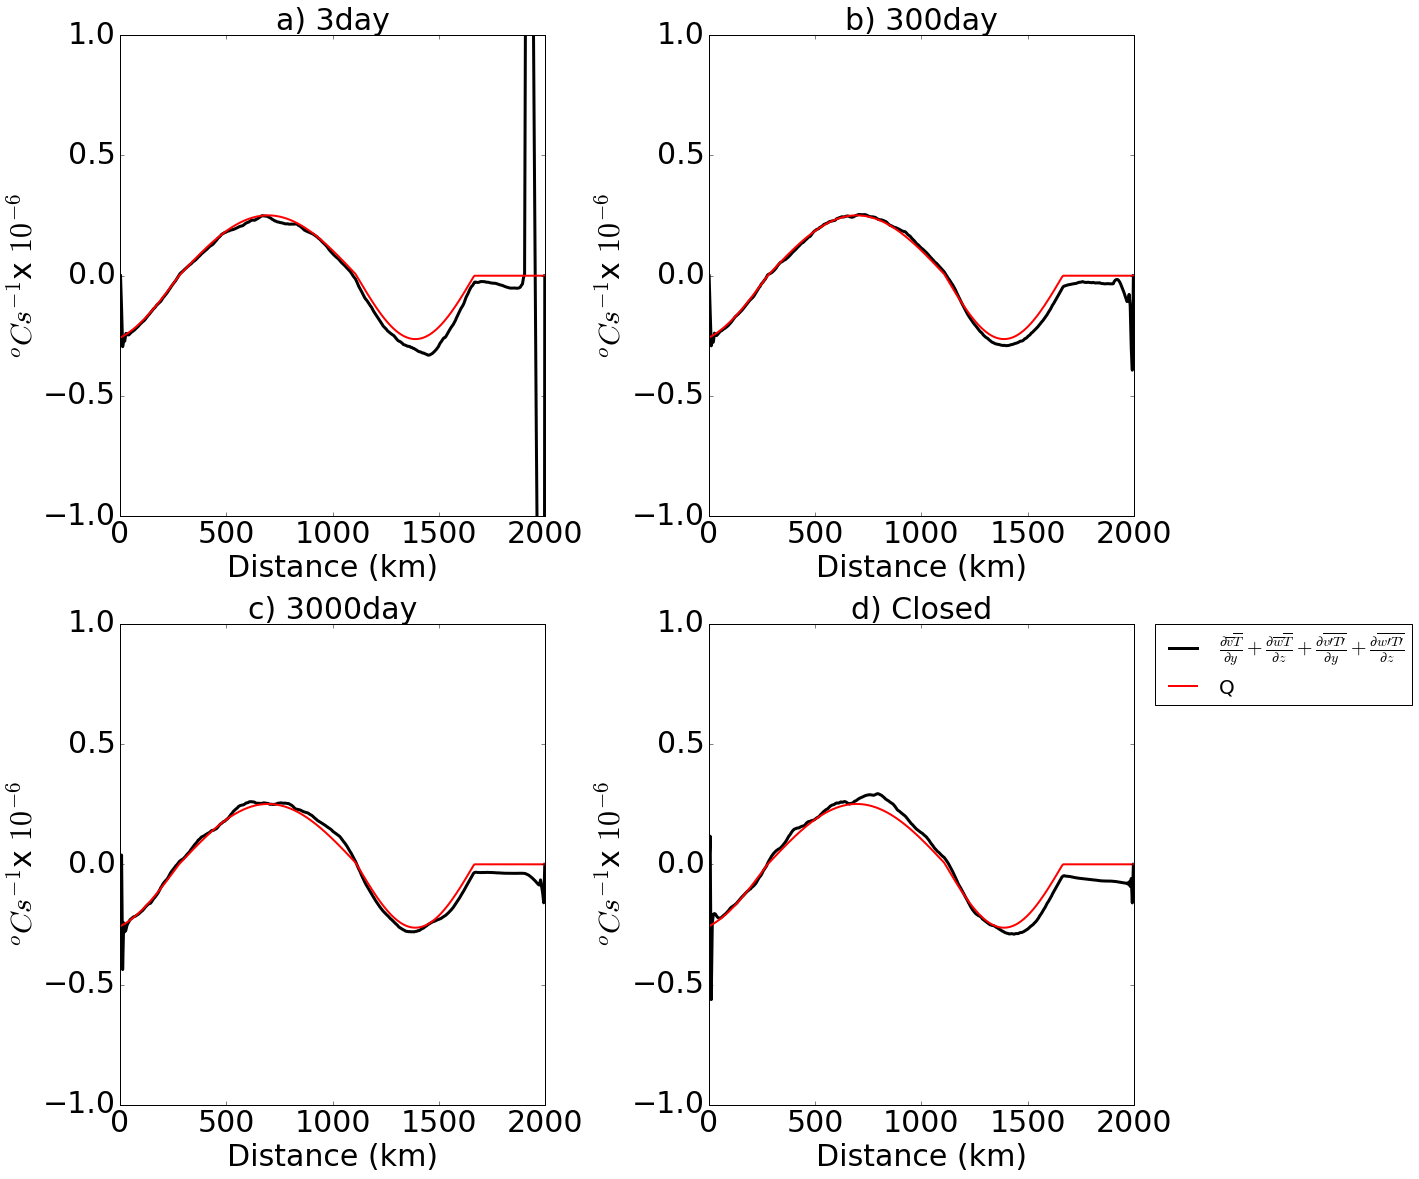

In [15]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*np.tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar                                                   
    # put everything on the C Grid                                                         
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((1, 0), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol#[0:-1,:,:]
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol#[0:-1,:,:]
    Adv = (dVTe.sum(axis=0) + dWTe.sum(axis=0) + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol)
    Diff = -(5000*Adv).mean(axis=1)
    Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000,(Diff+Surcor)*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(Psipred/c.dzf[0])*10**6,'r',linewidth=2)
    plt.ylim(-1,1)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'$\frac{\partial\overline{v}\overline{T}}{\partial y}+\frac{\partial\overline{w}\overline{T}}{\partial z}+\frac{\partial \overline{v\prime T\prime }}{\partial y} + \frac{\partial \overline{w\prime T\prime }}{\partial z} $'
                  ,'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

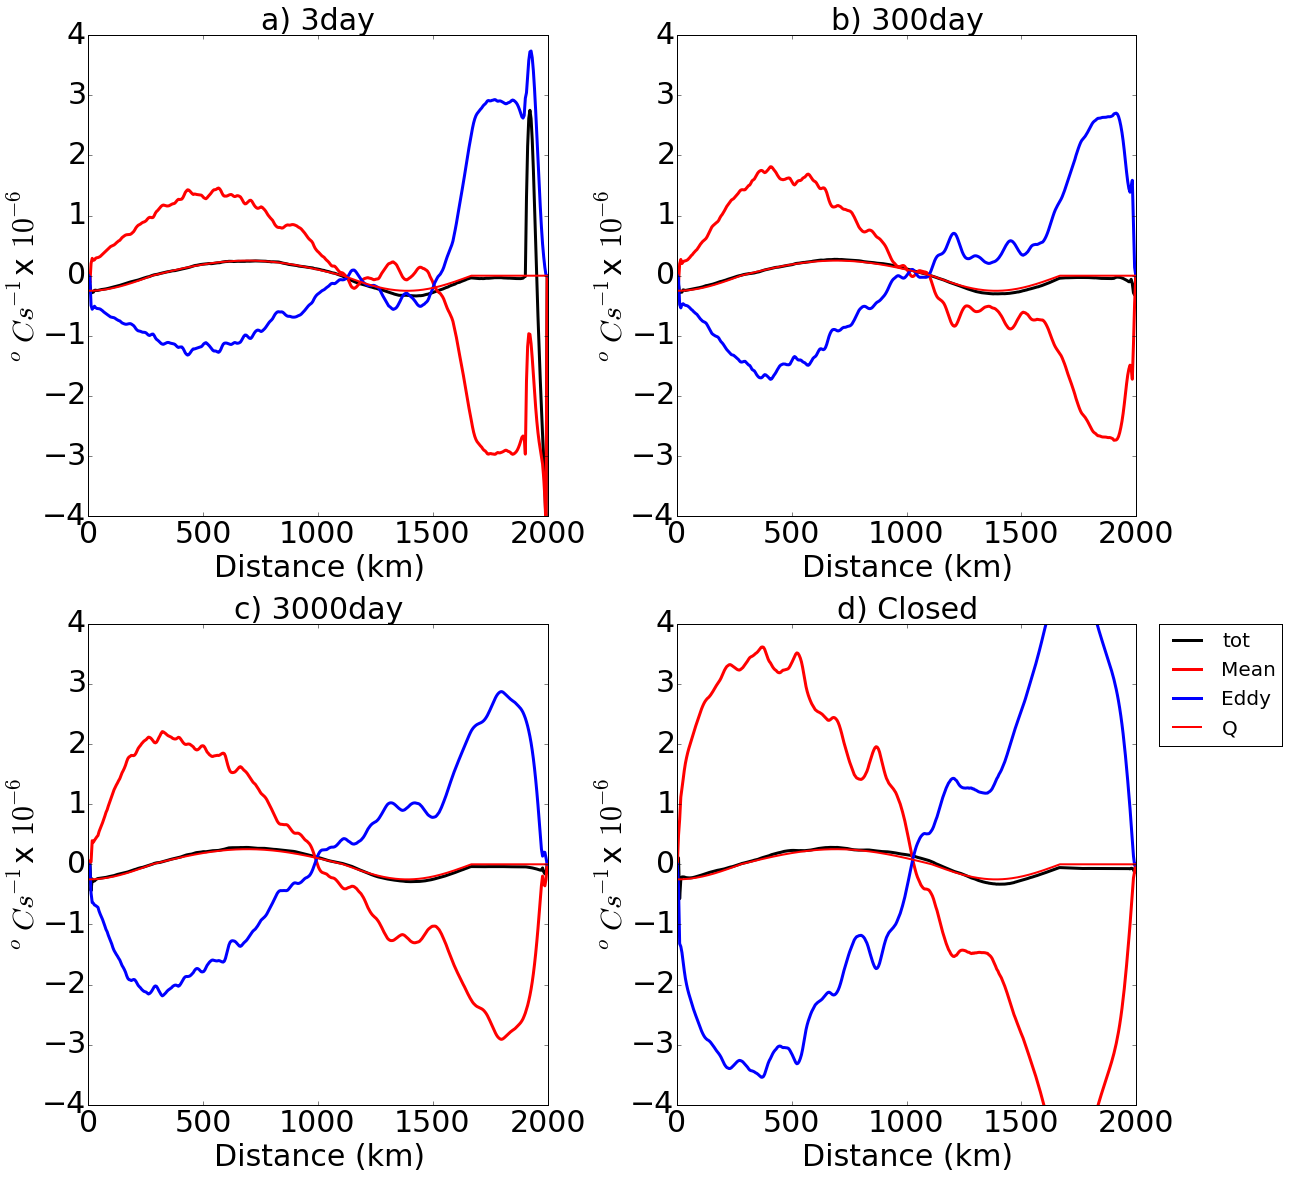

In [76]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar                                        
    # put everything on the C Grid                  
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = c.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = c.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol[0:-1,:,:]
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol[0:-1,:,:]
    Adv = (dVTe.sum(axis=0) + dWTe.sum(axis=0) + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol)
    Diff = -(5000*Adv).mean(axis=1)
    M = -5000*((dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol)).mean(axis=1)
    E = -5000*((dVTe.sum(axis=0) + dWTe.sum(axis=0))/sum(CellVol)).mean(axis=1)
    Ly = 2000e3
    Lx = 1000e3
    nx = np.round(Lx/5000)
    ny = np.round(Ly/5000)
    Q_0 = 10
    Q = np.zeros_like(c.yc)
    pi = math.pi
    Q=np.zeros(np.shape(Q))
    Q[0:int(5*ny/36)] = Q_0*(np.cos(c.yc[0:int(5*ny/36)]*(pi/(c.yc[int(10*ny/36)]))))
    Q[int(5*ny/36):int(20*ny/36)] = -Q_0*(np.sin((c.yc[int(5*ny/36):int(20*ny/36)]
                                                  -c.yc[int(5*ny/36)])*(pi/(c.yc[int(15*ny/36)]))))
    Q[int(20*ny/36):int(30*ny/36)] = Q_0*(np.sin(c.yc[0:int(10*ny/36)]*(pi/(c.yc[int(10*ny/36)]))))
    Psipred = -(Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000,(Diff+Surcor)*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(M+Surcor)*10**6,'r',linewidth=3)
    p = plt.plot(c.yc/1000,(E+Surcor)*10**6,'b',linewidth=3)
    p = plt.plot(c.yc/1000,(Psipred/c.dzf[0])*10**6,'r',linewidth=2)
    plt.ylim(-4,4)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'tot','Mean','Eddy',
                  'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

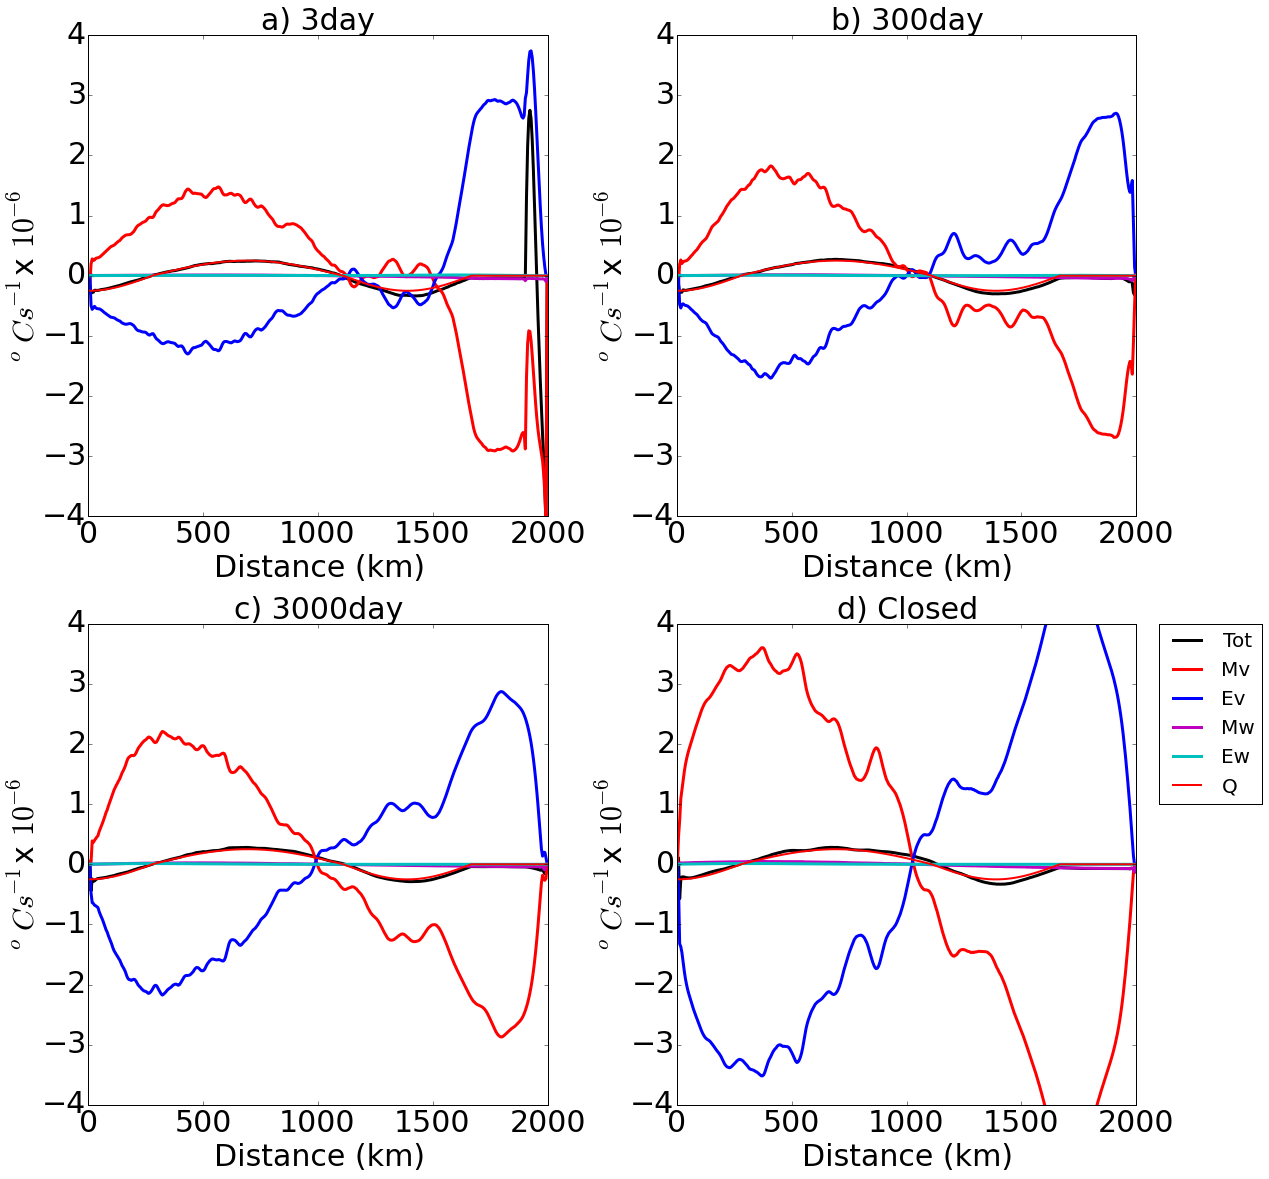

In [77]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar                                                                                                                    
    # put everything on the C Grid                                                                                                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = c.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = c.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol[0:-1,:,:]
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol[0:-1,:,:]
    Adv = (dVTe.sum(axis=0) + dWTe.sum(axis=0) + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol)
    Diff = -(5000*Adv).mean(axis=1)
    Mv = -5000*((dVTbar.sum(axis=0))/sum(CellVol)).mean(axis=1)
    Ev = -5000*((dVTe.sum(axis=0))/sum(CellVol)).mean(axis=1)
    Mw = -5000*((dWTbar.sum(axis=0))/sum(CellVol)).mean(axis=1)
    Ew = -5000*((dWTe.sum(axis=0))/sum(CellVol)).mean(axis=1)
    Ly = 2000e3
    Lx = 1000e3
    nx = np.round(Lx/5000)
    ny = np.round(Ly/5000)
    Q_0 = 10
    Q = np.zeros_like(c.yc)
    pi = math.pi
    Q=np.zeros(np.shape(Q))
    Q[0:int(5*ny/36)] = Q_0*(np.cos(c.yc[0:int(5*ny/36)]*(pi/(c.yc[int(10*ny/36)]))))
    Q[int(5*ny/36):int(20*ny/36)] = -Q_0*(np.sin((c.yc[int(5*ny/36):int(20*ny/36)]-c.yc[int(5*ny/36)])*(pi/(c.yc[int(15*ny/36)]))))
    Q[int(20*ny/36):int(30*ny/36)] = Q_0*(np.sin(c.yc[0:int(10*ny/36)]*(pi/(c.yc[int(10*ny/36)]))))
    Psipred = -(Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000,(Diff+Surcor)*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(Mv)*10**6,'r',linewidth=3)
    p = plt.plot(c.yc/1000,(Ev)*10**6,'b',linewidth=3)
    p = plt.plot(c.yc/1000,(Mw)*10**6,'m',linewidth=3)
    p = plt.plot(c.yc/1000,(Ew)*10**6,'c',linewidth=3)
    p = plt.plot(c.yc/1000,(Psipred/c.dzf[0])*10**6,'r',linewidth=2)
    plt.ylim(-4,4)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'Tot','Mv','Ev','Mw','Ew',
                  'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

\begin{equation}
\frac{\partial \overline{v}\overline{T}}{\partial y } + \frac{\partial\overline{w} \overline{T}}{\partial z } + \frac{\partial \overline{v'T'}S_p}{\partial z } + \frac{\partial \overline{v'T'}}{\partial y } = \frac{\partial Q}{\partial z}+ \frac{\partial \left( \overline{w'T'}-\overline{v'T'}S_p \right)}{\partial z }.
\end{equation}

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:31: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:31: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:33: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:34: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:35: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:33: RuntimeWarning: invalid value encountered in subtract
/noc/users/hb1g13/anaco

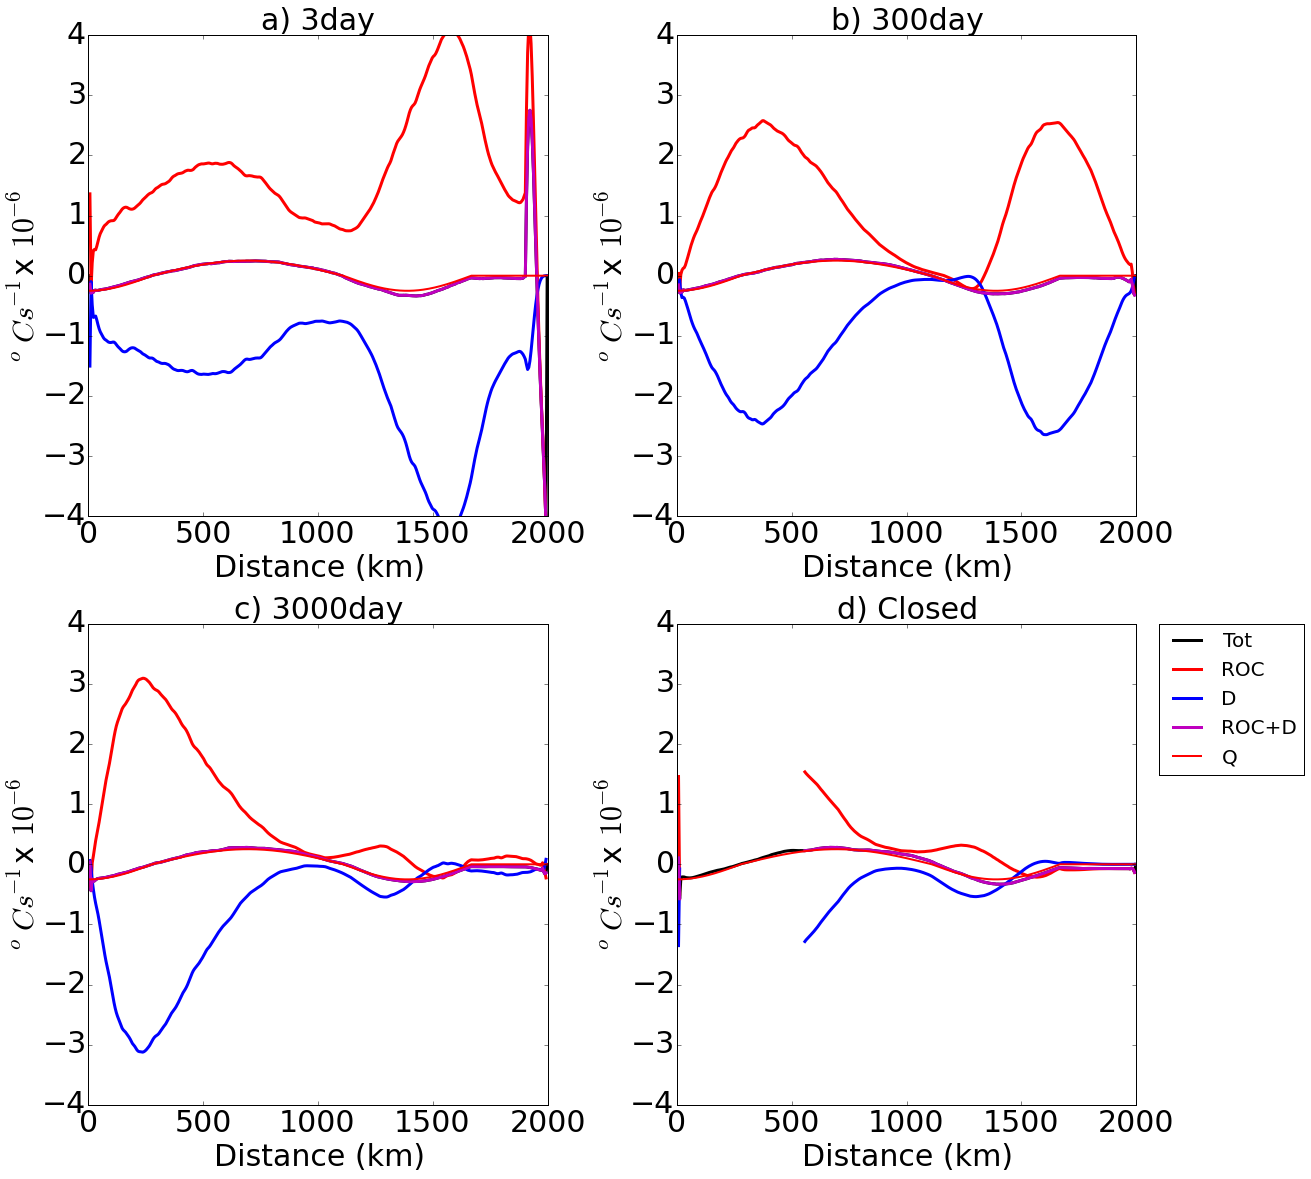

In [78]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = c.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = c.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol[0:-1,:,:]
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol[0:-1,:,:]
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol[0:-1,:,:]
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp[0:-1,:,:] = -Ty[0:-1,:,:]/Tz
    Ade = ((c.vgrid_to_cgrid(VpTp)*Sp)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTp)*Sp)[0:-1,:,:])*CellVol[0:-1,:,:] 
    DE = ((WpTp-(c.vgrid_to_cgrid(VpTp)*Sp))[1::,:,:] 
          - (WpTp-(c.vgrid_to_cgrid(VpTp)*Sp))[0:-1,:,:])*CellVol[0:-1,:,:] 
    D = -5000*((DE.sum(axis=0))/sum(CellVol)).mean(axis=1)
    ROC =-5000*((Ade.sum(axis=0) + dVTe.sum(axis=0) 
                 + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol)).mean(axis=1)
    Adv = ((dVTe.sum(axis=0) + dWTe.sum(axis=0)
           + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol))
    Diff = -(5000*Adv).mean(axis=1)
    Ly = 2000e3
    Lx = 1000e3
    nx = np.round(Lx/5000)
    ny = np.round(Ly/5000)
    Q_0 = 10
    Q = np.zeros_like(c.yc)
    pi = math.pi
    Q=np.zeros(np.shape(Q))
    Q[0:int(5*ny/36)] = Q_0*(np.cos(c.yc[0:int(5*ny/36)]*(pi/(c.yc[int(10*ny/36)]))))
    Q[int(5*ny/36):int(20*ny/36)] = -Q_0*(np.sin((c.yc[int(5*ny/36):int(20*ny/36)]
                                                  -c.yc[int(5*ny/36)])*(pi/(c.yc[int(15*ny/36)]))))
    Q[int(20*ny/36):int(30*ny/36)] = Q_0*(np.sin(c.yc[0:int(10*ny/36)]*(pi/(c.yc[int(10*ny/36)]))))
    Psipred = -(Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000,(Diff+Surcor)*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC)*10**6,'r',linewidth=3)
    p = plt.plot(c.yc/1000,(D)*10**6,'b',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC+D+Surcor)*10**6,'m',linewidth=3)
    p = plt.plot(c.yc/1000,(Psipred/c.dzf[0])*10**6,'r',linewidth=2)
    plt.ylim(-4,4)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'Tot','ROC','D','ROC+D','Q',
                  'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

**MIXED LAYER DEPTH Budget**

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:41: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:41: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:42: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:43: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:44: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:45: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:43: RuntimeWarning: invalid value encountered in subtract
/noc/users/hb1g13/anaco

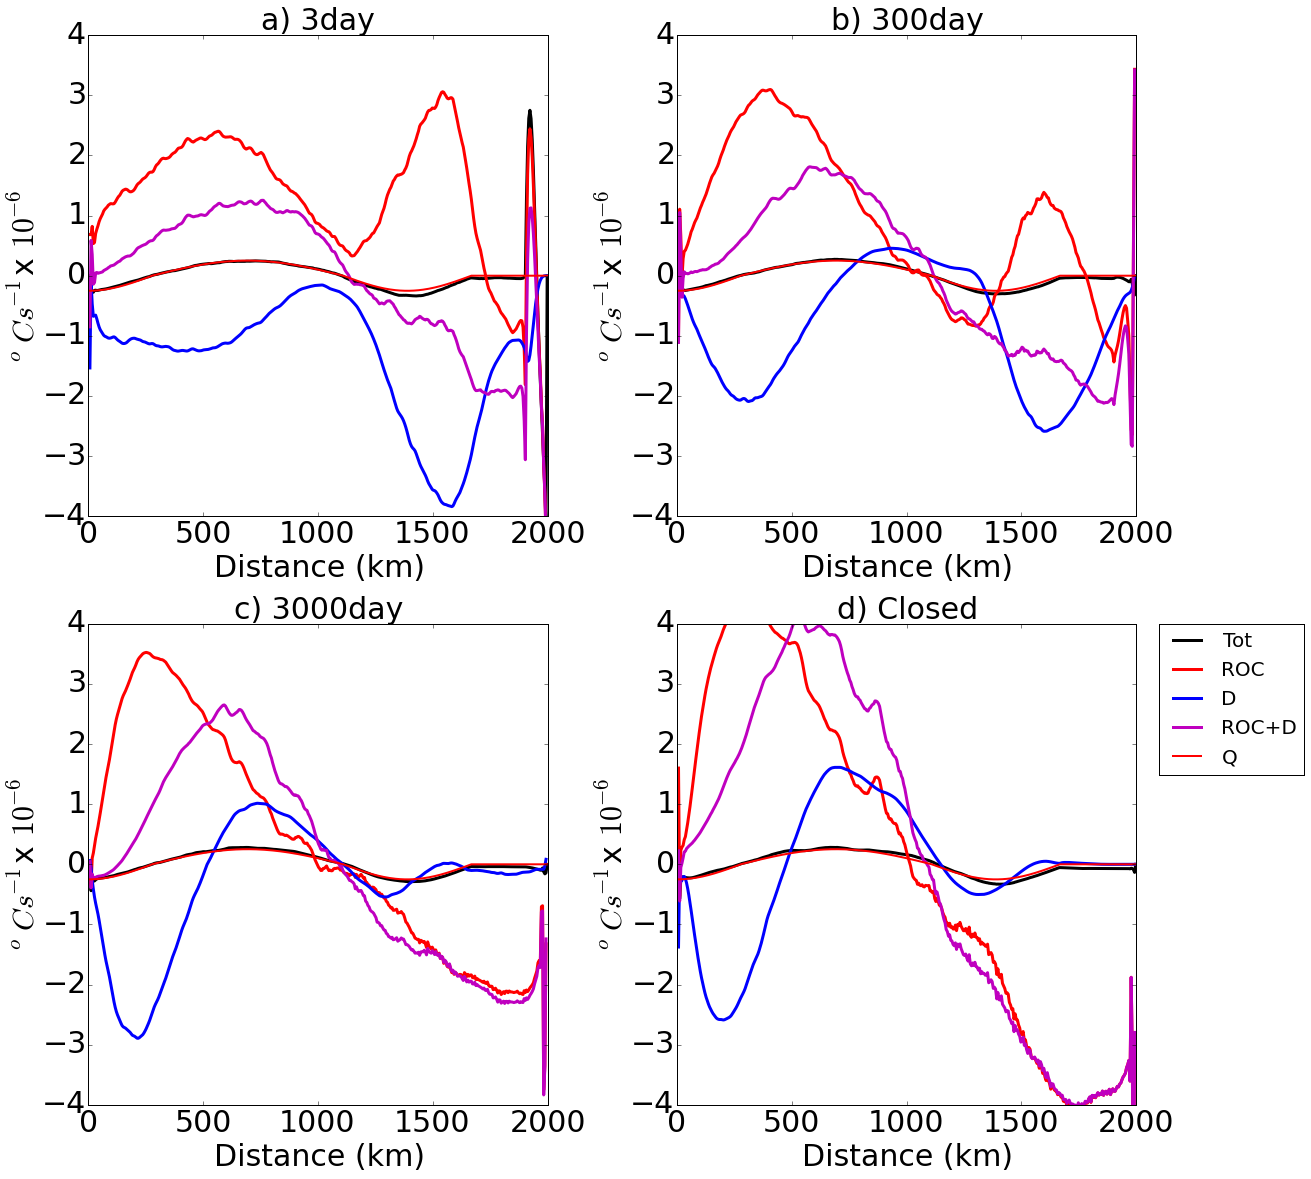

In [90]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = c.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = c.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    MLD = (c.mnc('MLD.nc','MXLDEPTH')).mean(axis=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    # LAYERS STYLE ITERPOLATION
    FineGridFact = 10
    ZFFp = np.zeros((300))
    ZFF = np.zeros((300))
    for kk in range((c.Nz)):
        ZFFp[10*kk:10*kk+10] = np.linspace(c.zf[kk],c.zf[kk+1],10)
    for kk in range(c.Nz-1):
        ZFF[10*kk:10*kk+10] = np.linspace(c.zc[kk],c.zc[kk+1],10)
    ZFF[-10::] = np.linspace(c.zc[-1],c.zf[-1],10)
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol[0:-1,:,:]
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol[0:-1,:,:]
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol[0:-1,:,:]
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp[0:-1,:,:] = -Ty[0:-1,:,:]/Tz
    Ade = ((c.vgrid_to_cgrid(VpTp)*Sp)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTp)*Sp)[0:-1,:,:])*CellVol[0:-1,:,:] 
    DE = ((WpTp-(c.vgrid_to_cgrid(VpTp)*Sp))[1::,:,:] 
          - (WpTp-(c.vgrid_to_cgrid(VpTp)*Sp))[0:-1,:,:])*CellVol[0:-1,:,:] 
    Mx_mask = zeros_like(CellVol)
    for iz in range(c.Nz-1):
        for iy in range(c.Ny-1):
            for ix in range(c.Nx-1):
                if c.zc[iz]<-MLD[iy,ix]:
                    MSK = 0
                else:
                    MSK = 1
                Mx_mask[iz,iy,ix] = MSK
    
    D = -5000*(((DE*Mx_mask[0:-1]).sum(axis=0))/sum(CellVol)).mean(axis=1)
    ROC =-5000*(((Ade*Mx_mask[0:-1]).sum(axis=0) + (dVTe*Mx_mask).sum(axis=0) 
                 + (dVTbar*Mx_mask).sum(axis=0) + (dWTbar*Mx_mask[0:-1]).sum(axis=0))/sum(CellVol)).mean(axis=1)
    Adv = ((dVTe.sum(axis=0) + dWTe.sum(axis=0)
           + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol))
    Diff = -(5000*Adv).mean(axis=1)
    Ly = 2000e3
    Lx = 1000e3
    nx = np.round(Lx/5000)
    ny = np.round(Ly/5000)
    Q_0 = 10
    Q = np.zeros_like(c.yc)
    pi = math.pi
    Q=np.zeros(np.shape(Q))
    Q[0:int(5*ny/36)] = Q_0*(np.cos(c.yc[0:int(5*ny/36)]*(pi/(c.yc[int(10*ny/36)]))))
    Q[int(5*ny/36):int(20*ny/36)] = -Q_0*(np.sin((c.yc[int(5*ny/36):int(20*ny/36)]
                                                  -c.yc[int(5*ny/36)])*(pi/(c.yc[int(15*ny/36)]))))
    Q[int(20*ny/36):int(30*ny/36)] = Q_0*(np.sin(c.yc[0:int(10*ny/36)]*(pi/(c.yc[int(10*ny/36)]))))
    Psipred = -(Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000,(Diff+Surcor)*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC)*10**6,'r',linewidth=3)
    p = plt.plot(c.yc/1000,(D)*10**6,'b',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC+D+Surcor)*10**6,'m',linewidth=3)
    p = plt.plot(c.yc/1000,(Psipred/c.dzf[0])*10**6,'r',linewidth=2)
    plt.ylim(-4,4)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'Tot','ROC','D','ROC+D','Q',
                  'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()